# Import

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Load Data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

# Preprocess and Merge Data

In [3]:
def preprocess(df, is_train=True):
    df = pd.merge(df, features, on=["Store", "Date", "IsHoliday"], how="left")
    df = pd.merge(df, stores, on="Store", how="left")
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
    df["Type"] = df["Type"].astype("category").cat.codes
    df["IsHoliday"] = df["IsHoliday"].astype(int)
    df.fillna(0, inplace=True)
    return df

train = preprocess(train)
test = preprocess(test, is_train=False)

# Select Features and Target


In [5]:
features_cols = [
    "Store", "Dept", "IsHoliday", "Temperature", "Fuel_Price",
    "CPI", "Unemployment", "Size", "Type", "Year", "Month", "Week",
    "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"
]

X_train = train[features_cols]
y_train = train["Weekly_Sales"]

X_test = test[features_cols]

# Train Linear Regression Model


In [6]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Prepare Submission


In [7]:
#Create Id column in the format store_dept_date
submission = test.copy()
submission['Id'] = submission['Store'].astype(str) + "_" + \
                   submission['Dept'].astype(str) + "_" + \
                   submission['Date'].dt.strftime("%Y-%m-%d")

#Add predictions
submission['Weekly_Sales'] = predictions

#Select required columns and save
submission[['Id', 'Weekly_Sales']].to_csv("Submission.csv", index=False)

# Plot sample store predictions


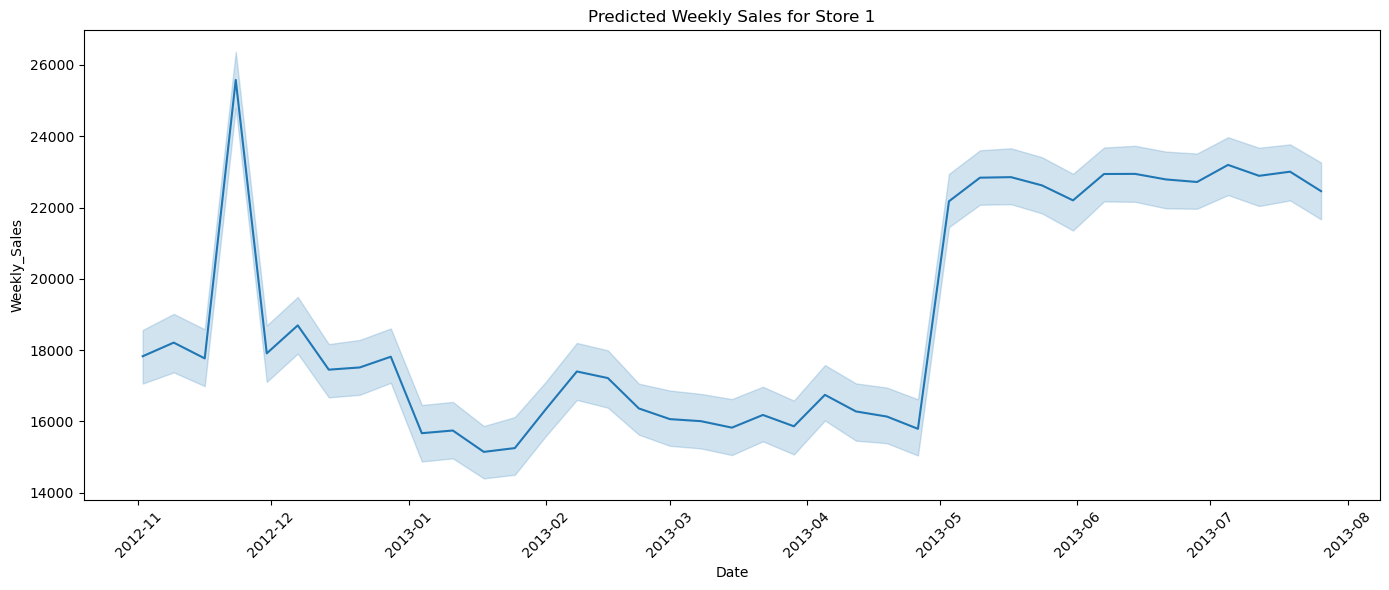

In [8]:
sample = submission[submission["Store"] == 1]
plt.figure(figsize=(14,6))
sns.lineplot(x="Date", y="Weekly_Sales", data=sample)
plt.title("Predicted Weekly Sales for Store 1")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 # Coefficients Plot (Feature Importance)

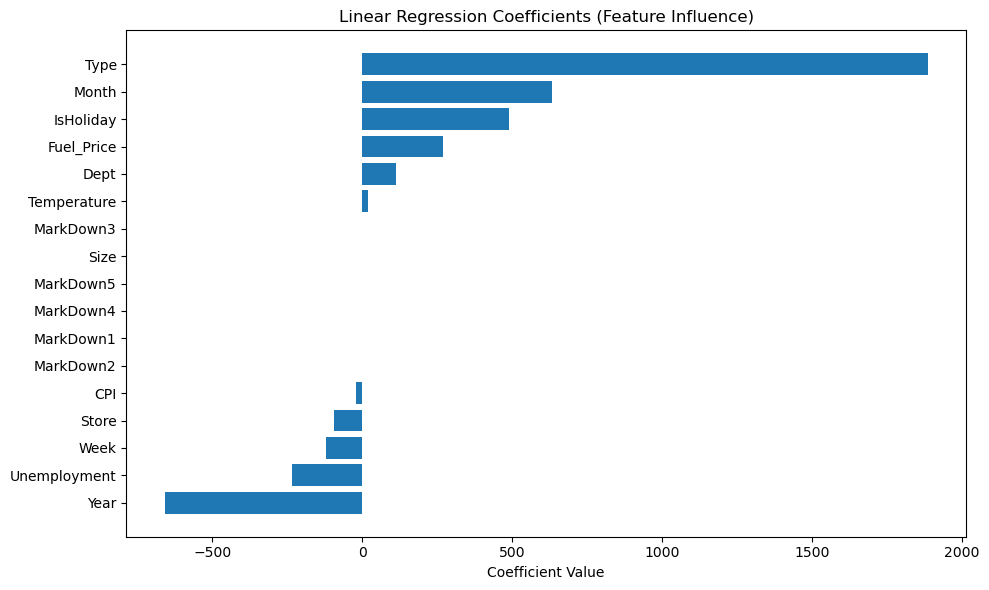

In [9]:
# Get coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
}).sort_values(by="Coefficient")

# Plot
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title("Linear Regression Coefficients (Feature Influence)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

# Predicted vs. Actual Plot (Model Performance)

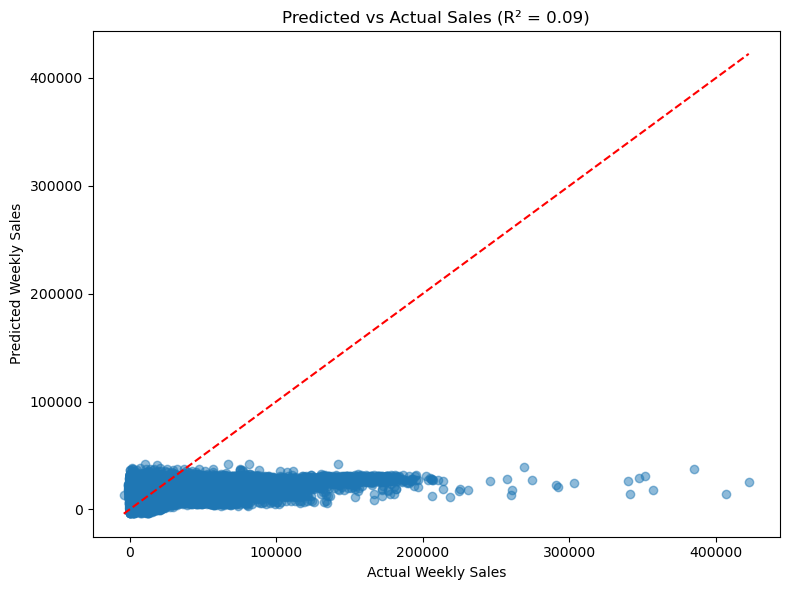

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split data to evaluate on holdout set
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train_part, y_train_part)
y_val_pred = model.predict(X_val)

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title(f"Predicted vs Actual Sales (R² = {r2_score(y_val, y_val_pred):.2f})")
plt.tight_layout()
plt.show()